<a href="https://colab.research.google.com/github/RamyaVidiyala/SpamDetectionInEmails/blob/master/SpamDetection.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import files
files.upload()

Saving spam.csv to spam.csv


{'spam.csv': b'v1,v2,,,\r\nham,"Go until jurong point, crazy.. Available only in bugis n great world la e buffet... Cine there got amore wat...",,,\r\nham,Ok lar... Joking wif u oni...,,,\r\nspam,Free entry in 2 a wkly comp to win FA Cup final tkts 21st May 2005. Text FA to 87121 to receive entry question(std txt rate)T&C\'s apply 08452810075over18\'s,,,\r\nham,U dun say so early hor... U c already then say...,,,\r\nham,"Nah I don\'t think he goes to usf, he lives around here though",,,\r\nspam,"FreeMsg Hey there darling it\'s been 3 week\'s now and no word back! I\'d like some fun you up for it still? Tb ok! XxX std chgs to send, \xe5\xa31.50 to rcv",,,\r\nham,Even my brother is not like to speak with me. They treat me like aids patent.,,,\r\nham,As per your request \'Melle Melle (Oru Minnaminunginte Nurungu Vettam)\' has been set as your callertune for all Callers. Press *9 to copy your friends Callertune,,,\r\nspam,WINNER!! As a valued network customer you have been selected to rece

In [ ]:
import pandas as pd
import re
import string
import numpy as np
from sklearn.feature_extraction.stop_words import ENGLISH_STOP_WORDS

/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:144: FutureWarning: The sklearn.feature_extraction.stop_words module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.feature_extraction.text. Anything that cannot be imported from sklearn.feature_extraction.text is now part of the private API.
  warnings.warn(message, FutureWarning)


In [ ]:
data = pd.read_csv("spam.csv",encoding = "'latin'")

In [ ]:
data.head()

,v1,v2,Unnamed: 2,Unnamed: 3,Unnamed: 4
0,ham,"Go until jurong point, crazy.. Available only ...",NaN,NaN,NaN
1,ham,Ok lar... Joking wif u oni...,NaN,NaN,NaN
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...,NaN,NaN,NaN
3,ham,U dun say so early hor... U c already then say...,NaN,NaN,NaN
4,ham,"Nah I don't think he goes to usf, he lives aro...",NaN,NaN,NaN


In [ ]:
data["text"] = data.v2
data["spam"] = data.v1

# Splitting data

In [ ]:
from sklearn.model_selection import train_test_split
emails_train, emails_test, target_train, target_test = train_test_split(data.text,data.spam,test_size = 0.2) 

In [ ]:
data.info

<bound method DataFrame.info of         v1  ...  spam
0      ham  ...   ham
1      ham  ...   ham
2     spam  ...  spam
3      ham  ...   ham
4      ham  ...   ham
...    ...  ...   ...
5564  spam  ...  spam
5565   ham  ...   ham
5566   ham  ...   ham
5567   ham  ...   ham
5568   ham  ...   ham

[5569 rows x 7 columns]>

In [ ]:
emails_train.shape

(4455,)

# Preprocessing

In [ ]:
def remove_hyperlink(word):
    return  re.sub(r"http\S+", "", word)

def to_lower(word):
    result = word.lower()
    return result

def remove_number(word):
    result = re.sub(r'\d+', '', word)
    return result

def remove_punctuation(word):
    result = word.translate(str.maketrans(dict.fromkeys(string.punctuation)))
    return result

def remove_whitespace(word):
    result = word.strip()
    return result

def replace_newline(word):
    return word.replace('\n','')



def clean_up_pipeline(sentence):
    cleaning_utils = [remove_hyperlink,
                      replace_newline,
                      to_lower,
                      remove_number,
                      remove_punctuation,remove_whitespace]
    for o in cleaning_utils:
        sentence = o(sentence)
    return sentence

x_train = [clean_up_pipeline(o) for o in emails_train]
x_test = [clean_up_pipeline(o) for o in emails_test]

x_train[0]

'does daddy have a bb now'

In [ ]:
from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()
train_y = le.fit_transform(target_train.values)
test_y = le.transform(target_test.values)

In [ ]:
train_y

array([0, 0, 0, ..., 0, 0, 0])

# Tokenize

In [ ]:
## some config values 
embed_size = 100 # how big is each word vector
max_feature = 50000 # how many unique words to use (i.e num rows in embedding vector)
max_len = 2000 # max number of words in a question to use

In [ ]:
from keras.preprocessing.text import Tokenizer
tokenizer = Tokenizer(num_words=max_feature)

tokenizer.fit_on_texts(x_train)

x_train_features = np.array(tokenizer.texts_to_sequences(x_train))
x_test_features = np.array(tokenizer.texts_to_sequences(x_test))

x_train_features[0]

[429, 1160, 17, 4, 949, 21]

# Padding

In [ ]:
from keras.preprocessing.sequence import pad_sequences
x_train_features = pad_sequences(x_train_features,maxlen=max_len)
x_test_features = pad_sequences(x_test_features,maxlen=max_len)
x_train_features[0]

array([  0,   0,   0, ...,   4, 949,  21], dtype=int32)

# Model

In [ ]:
from keras.layers import Dense, Input, LSTM, Embedding, Dropout, Activation
from keras.layers import Bidirectional
from keras.models import Model

In [ ]:
# create the model
import tensorflow as tf
embedding_vecor_length = 32

model = tf.keras.Sequential()
model.add(Embedding(max_feature, embedding_vecor_length, input_length=max_len))
model.add(Bidirectional(tf.keras.layers.LSTM(64)))
model.add(Dense(16, activation='relu'))
model.add(Dropout(0.1))
model.add(Dense(1, activation='sigmoid'))
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
print(model.summary())

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 2000, 32)          1600000   
_________________________________________________________________
bidirectional (Bidirectional (None, 128)               49664     
_________________________________________________________________
dense (Dense)                (None, 16)                2064      
_________________________________________________________________
dropout (Dropout)            (None, 16)                0         
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 17        
Total params: 1,651,745
Trainable params: 1,651,745
Non-trainable params: 0
_________________________________________________________________
None


In [ ]:
history = model.fit(x_train_features, train_y, batch_size=512, epochs=20, validation_data=(x_test_features, test_y))

Epoch 1/20
9/9 [==============================] - 419s 47s/step - loss: 0.6600 - accuracy: 0.7827 - val_loss: 0.5817 - val_accuracy: 0.8770
Epoch 2/20
9/9 [==============================] - 369s 41s/step - loss: 0.4773 - accuracy: 0.8635 - val_loss: 0.3810 - val_accuracy: 0.8770
Epoch 3/20
9/9 [==============================] - 176s 20s/step - loss: 0.3879 - accuracy: 0.8635 - val_loss: 0.3531 - val_accuracy: 0.8770
Epoch 4/20
9/9 [==============================] - 160s 18s/step - loss: 0.3508 - accuracy: 0.8635 - val_loss: 0.2889 - val_accuracy: 0.8770
Epoch 5/20
9/9 [==============================] - 155s 17s/step - loss: 0.2519 - accuracy: 0.8813 - val_loss: 0.1653 - val_accuracy: 0.9560
Epoch 6/20
9/9 [==============================] - 158s 18s/step - loss: 0.1234 - accuracy: 0.9708 - val_loss: 0.1069 - val_accuracy: 0.9686
Epoch 7/20
9/9 [==============================] - 149s 17s/step - loss: 0.0705 - accuracy: 0.9825 - val_loss: 0.0842 - val_accuracy: 0.9731
Epoch 8/20
9/9 [====

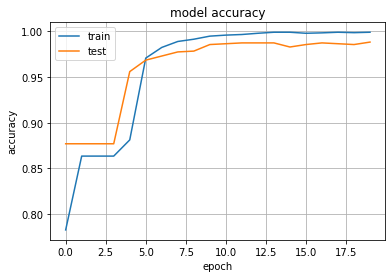

In [ ]:
from  matplotlib import pyplot as plt
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.grid()
plt.show()


In [ ]:
from sklearn.metrics import confusion_matrix,f1_score, precision_score,recall_score

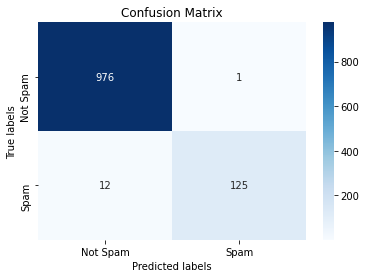

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt     

ax= plt.subplot()
sns.heatmap(cf_matrix, annot=True, ax = ax,cmap='Blues',fmt=''); #annot=True to annotate cells

# labels, title and ticks
ax.set_xlabel('Predicted labels');
ax.set_ylabel('True labels'); 
ax.set_title('Confusion Matrix'); 
ax.xaxis.set_ticklabels(['Not Spam', 'Spam']); ax.yaxis.set_ticklabels(['Not Spam', 'Spam']);

In [ ]:
y_predict  = [1 if o>0.5 else 0 for o in model.predict(x_test_features)]

In [ ]:
cf_matrix =confusion_matrix(test_y,y_predict)

In [ ]:
tn, fp, fn, tp = confusion_matrix(test_y,y_predict).ravel()

In [ ]:
print("Precision: {:.2f}%".format(100 * precision_score(test_y, y_predict)))
print("Recall: {:.2f}%".format(100 * recall_score(test_y, y_predict)))
print("F1 Score: {:.2f}%".format(100 * f1_score(test_y,y_predict)))

Precision: 99.21%
Recall: 91.24%
F1 Score: 95.06%


In [ ]:
f1_score(test_y,y_predict)

0.9505703422053231